# Convolutional Neural Networks

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adagrad

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input # Changed the import to be from keras.layers
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU # Moved LeakyReLU import to keras.layers

# Cargar set de Imágenes

In [3]:
#dirname = os.path.join(os.getcwd(), 'sportimages')
dirname = os.path.join(os.getcwd(), 'datos')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    head_tail  = os.path.split(root)
    if head_tail[1] == 'ALLDB' or head_tail[1] == 'HEMDB' :
        for filename in filenames:
            if re.search("\.(jpg|jpeg|png|bmp|tif)$", filename):
                cant=cant+1
                filepath = os.path.join(root, filename)
                image = plt.imread(filepath)
                images.append(image)
                b = "Leyendo..." + str(cant)
                print (b, end="\r")
                if prevRoot !=root:
                    print(root, cant)
                    prevRoot=root
                    directories.append(root)
                    dircount.append(cant)
                    cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\Laura Valbuena\Documents\Proyecto\M1000-IA--LLA-\datos\
C:\Users\Laura Valbuena\Documents\Proyecto\M1000-IA--LLA-\datos\ALLDB\ALLDB 1
C:\Users\Laura Valbuena\Documents\Proyecto\M1000-IA--LLA-\datos\HEMDB\HEMDB 7272
Directorios leidos: 2
Imagenes en cada directorio [7273, 3388]
suma Total de imagenes en subdirs: 10661


# Creamos las etiquetas

In [4]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  10661


In [5]:
estado=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    estado.append(name[len(name)-1])
    indice=indice+1

0 ALLDB
1 HEMDB


In [6]:
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter


# Obtener los tamaños de las imágenes y contar ocurrencias
image_sizes = Counter((img.shape[0], img.shape[1]) for img in images)

# Imprimir los tamaños únicos y la cantidad de imágenes para cada tamaño
print("Tamaños únicos de imágenes y cantidad:")
for size, count in image_sizes.items():
    print(f"Tamaño: {size}, Cantidad: {count}")

Tamaños únicos de imágenes y cantidad:
Tamaño: (450, 450), Cantidad: 10661


In [7]:
def resize_images(images, desired_size):
  resized_images = []
  for img in images:
    if len(img.shape) == 2: # Si la imagen es en escala de grises
      resized_img = cv2.resize(img, desired_size, interpolation=cv2.INTER_AREA)
    else: # Si la imagen es a color
      resized_img = cv2.resize(img, desired_size, interpolation=cv2.INTER_CUBIC)
    resized_images.append(resized_img)
  return resized_images

In [8]:
desired_size = (257, 257) # Define el tamaño deseado
resized_images = resize_images(images, desired_size)
del images
del directories
del dircount

In [9]:
X = np.array(resized_images, dtype=np.uint8)
#del resized_images

In [10]:
y = np.array(labels)
#X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
del labels

Total number of outputs :  2
Output classes :  [0 1]


# Creamos Sets de Entrenamiento y Test

In [11]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (8528, 257, 257, 3) (8528,)
Testing data shape :  (2133, 257, 257, 3) (2133,)


In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, random_state=42) 

#80% entrenamiento y 20% prueba
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)


Training data shape :  (8528, 257, 257, 3) (8528,)
Testing data shape :  (2133, 257, 257, 3) (2133,)


Text(0.5, 1.0, 'Ground Truth : 0')

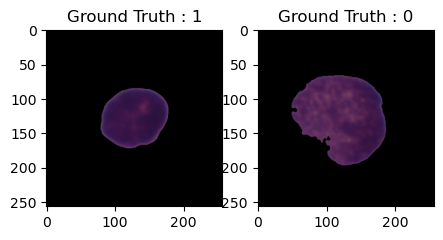

In [13]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 257.
test_X = test_X / 257.

## Hacemos el One-hot Encoding para la red

In [15]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
del train_Y 

Original label: 1
After conversion to one-hot: [0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [16]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [17]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(6822, 257, 257, 3) (1706, 257, 257, 3) (6822, 2) (1706, 2)


# Creamos el modelo de CNN

In [18]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
#INIT_LR = 0.001 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [19]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(257,257,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [20]:
sport_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 257, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 257, 257, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 129, 129, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 129, 129, 32)      0         
                                                                 
 flatten (Flatten)           (None, 532512)            0         
                                                                 
 dense (Dense)               (None, 32)                17040416  
                                                        

In [21]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR, weight_decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [22]:
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/6


107/107 [==============================] - 169s 2s/step - loss: 0.5063 - accuracy: 0.7744 - val_loss: 0.4691 - val_accuracy: 0.7943
Epoch 2/6
107/107 [==============================] - 157s 1s/step - loss: 0.4659 - accuracy: 0.8034 - val_loss: 0.4603 - val_accuracy: 0.7919
Epoch 3/6
107/107 [==============================] - 167s 2s/step - loss: 0.4625 - accuracy: 0.8075 - val_loss: 0.4588 - val_accuracy: 0.7931
Epoch 4/6
107/107 [==============================] - 164s 2s/step - loss: 0.4565 - accuracy: 0.8062 - val_loss: 0.4570 - val_accuracy: 0.7896
Epoch 5/6
107/107 [==============================] - 159s 1s/step - loss: 0.4550 - accuracy: 0.8089 - val_loss: 0.4559 - val_accuracy: 0.7925
Epoch 6/6
107/107 [==============================] - 158s 1s/step - loss: 0.4497 - accuracy: 0.8094 - val_loss: 0.4557 - val_accuracy: 0.7943


In [23]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

INFO:tensorflow:Assets written to: sports_mnist.h5py\assets


INFO:tensorflow:Assets written to: sports_mnist.h5py\assets


# Evaluamos la red

In [24]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

67/67 [==============================] - 10s 148ms/step - loss: 0.4605 - accuracy: 0.7937


In [25]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.46046823263168335
Test accuracy: 0.7937177419662476


In [26]:
print(sport_train.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


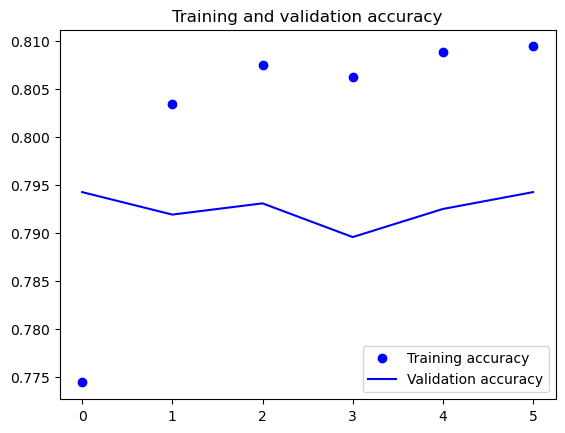

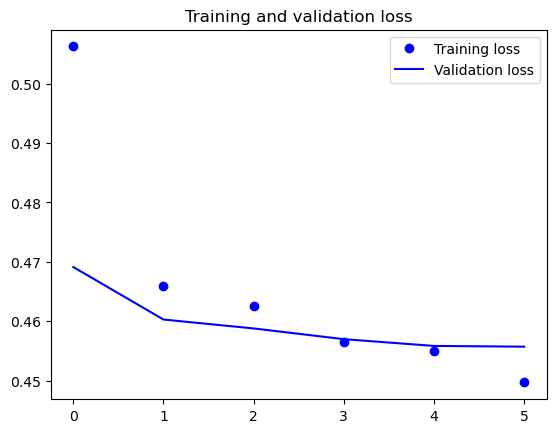

In [27]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
predicted_classes2 = sport_model.predict(test_X)

67/67 [==============================] - 9s 125ms/step


In [29]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [30]:
predicted_classes.shape, test_Y.shape

((2133,), (2133,))

# Aprendamos de los errores: Qué mejorar

Found 1693 correct labels


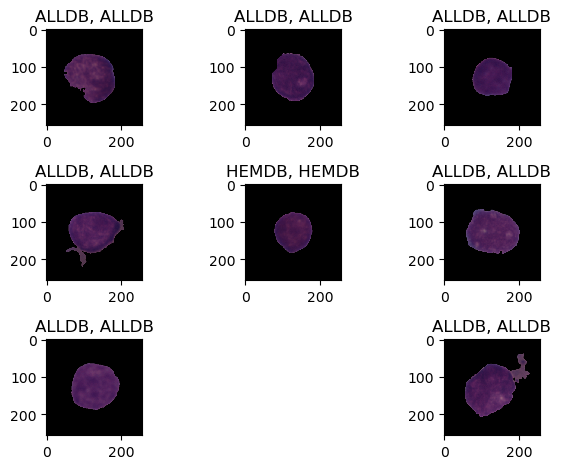

In [31]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(257,257,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(estado[predicted_classes[correct]],
                                                    estado[test_Y[correct]]))

    plt.tight_layout()

Found 440 incorrect labels


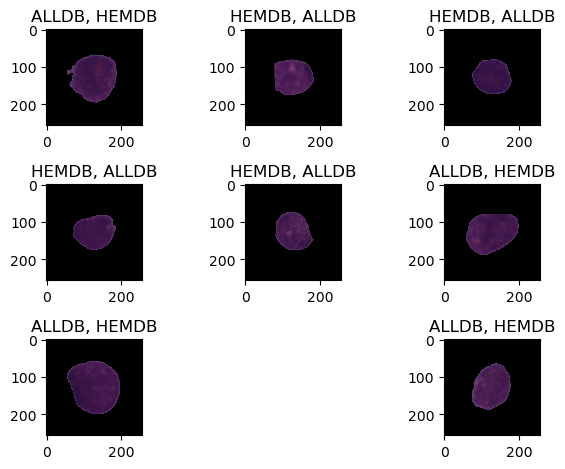

In [32]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(257,257,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(estado[predicted_classes[incorrect]],
                                                    estado[test_Y[incorrect]]))
    plt.tight_layout()

In [33]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.82      0.89      0.86      1456
     Class 1       0.72      0.58      0.64       677

    accuracy                           0.79      2133
   macro avg       0.77      0.74      0.75      2133
weighted avg       0.79      0.79      0.79      2133



Class 0: Benign

Class 1: Malignant

# Prediccion de una nueva imagen

In [34]:
#dirname = os.path.join(os.getcwd(), 'sportimages')
dirname = os.path.join(os.getcwd(), 'datos/Val/validation_data')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tif)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            image = plt.imread(filepath,0)
            image_resized = resize(image, (257, 257),anti_aliasing=True,clip=False,preserve_range=True)
            images.append(image_resized)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\Laura Valbuena\Documents\Proyecto\M1000-IA--LLA-\datos/Val/validation_data\
C:\Users\Laura Valbuena\Documents\Proyecto\M1000-IA--LLA-\datos/Val/validation_data\ 1
Directorios leidos: 1
Imagenes en cada directorio [1867]
suma Total de imagenes en subdirs: 1867


In [35]:
X = np.array(image_resized, dtype=np.uint8)
test_X = X.astype('float32')
test_X = test_X / 257.

In [ ]:
predicted_classes = sport_model.predict(test_X)
for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], estado[img_tagged.tolist().index(max(img_tagged))])